In [1]:
import tensorflow as tf
tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from model_mobile import get_model
from utils import Metrics

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
DATA_DIR = '/tf/Modified/covid19_pocus_ultrasound_master/covid19_pocus_ultrasound_master/data/cross_validation'
MODEL_DIR = '/tf/Modified/covid19_pocus_ultrasound_master/covid19_pocus_ultrasound_master/models'
FOLD = 0
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 16
TRAINABLE_BASE_LAYERS = 1
IMG_WIDTH, IMG_HEIGHT = (224,224)

In [4]:

model_name = 'pocus_fold_{0}'
plot_path = 'pocus_fold_{0}'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print('Loading images...')
imagePaths = list(paths.list_images(DATA_DIR))
data = []
labels = []

print('Model is called : {model_name}')
print('selected fold: {FOLD}')

train_labels, test_labels = [], []
train_data, test_data = [], []

Loading images...
Model is called : {model_name}
selected fold: {FOLD}


In [5]:
for imagePath in imagePaths:
    path_parts = imagePath.split(os.path.sep)
    # extract the split
    train_test = path_parts[-3][-1]
    # extract the class label from the filename
    label = path_parts[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # update the data and labels lists, respectively
    if train_test == str(FOLD):
        test_labels.append(label)
        test_data.append(image)
    else:
        train_labels.append(label)
        train_data.append(image)

# Prepare data for model
print(
    '\nNumber of training samples: len(train_labels) \n'
    'Number of testing samples: len(test_labels)'
)


Number of training samples: len(train_labels) 
Number of testing samples: len(test_labels)


In [6]:
len(test_labels)

428

In [7]:

assert len(set(train_labels)) == len(set(test_labels)), (
    'Something went wrong. Some classes are only in train or test data.'
)  # yapf: disable

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
train_data = np.array(train_data) / 255.0
test_data = np.array(test_data) / 255.0
train_labels_text = np.array(train_labels)
test_labels_text = np.array(test_labels)

num_classes = len(set(train_labels))

# perform one-hot encoding on the labels
lb = LabelBinarizer()
lb.fit(train_labels_text)

train_labels = lb.transform(train_labels_text)
test_labels = lb.transform(test_labels_text)

In [8]:

if num_classes == 2:
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    test_labels = to_categorical(test_labels, num_classes=num_classes)

trainX = train_data
trainY = train_labels
testX = test_data
testY = test_labels
print('Class mappings are:', lb.classes_)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Load the VGG16 network
model = get_model(
    input_size=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes
)

Class mappings are: ['covid' 'pneumonia' 'regular']


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [9]:
num_layers = len(model.layers)
num_layers

94

In [10]:

# Number of layers in model head (fresh weights), this is fixed in get_model.
#num_head_layers =30
# Freeze all VGG layers apart from the last layers (TRAINABLE_BASE_LAYERS)
#num_layers = len(model.layers)
#for ind, layer in enumerate(model.layers):
#    if ind < num_layers - num_head_layers - TRAINABLE_BASE_LAYERS:
#        layer.trainable = False

# Define callbacks
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'fold_' + str(FOLD) + '_epoch_{epoch:02d}'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    verbose=1,
    epsilon=1e-4,
    mode='min'
)
# To show balanced accuracy
metrics = Metrics((testX, testY), model)

# compile model
print('Compiling model...')
opt = Adam(lr=LR, decay=LR / EPOCHS)
model.compile(
    loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']
)

print('Model has {model.count_params()} parameters')
print('Model summary {model.summary()}')
model.summary()

Compiling model...
Model has {model.count_params()} parameters
Model summary {model.summary()}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
________________________________

In [11]:

# train the head of the network
print('Starting training model...')
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss, metrics]
)

# make predictions on the testing set
print('Evaluating network...')
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)


Starting training model...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 115 steps, validate on 428 samples
Epoch 1/50
114/115 [============================>.] - ETA: 0s - loss: 1.0407 - accuracy: 0.5485
Epoch 00001: val_accuracy improved from -inf to 0.81731, saving model to /tf/Modified/covid19_pocus_ultrasound_master/covid19_pocus_ultrasound_master/models/fold_0_epoch_01
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tf/Modified/covid19_pocus_ultrasound_master/covid19_pocus_ultrasound_master/models/fold_0_epoch_01/assets
Balanced accuracy is: {'val_balanced': 0.796551724137931}
115/115 [==============================] - 46s 402ms/step - loss: 1.0364 - accuracy: 0.5508 - val_loss: 0.6073 - val_accuracy: 0.8173
Epoch 2/50
114/115 [============================>.] - ETA: 0s - loss: 0.4546 - accuracy: 0.8341
Epoch 00002: val_accuracy improved from 0.81731

In [12]:
print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

classification report sklearn:
              precision    recall  f1-score   support

       covid       0.97      1.00      0.99       232
   pneumonia       0.97      0.97      0.97       116
     regular       0.95      0.88      0.91        80

    accuracy                           0.97       428
   macro avg       0.96      0.95      0.95       428
weighted avg       0.97      0.97      0.97       428



confusion matrix:
[[232   0   0]
 [  0 112   4]
 [  6   4  70]]
Saving COVID-19 detector model on {model_name} data...
Done, shuttting down!


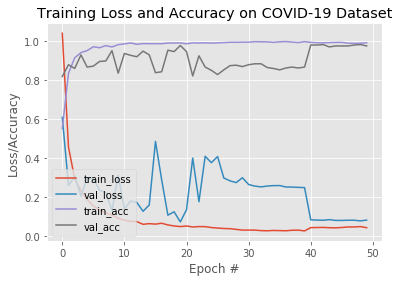

In [13]:
print('confusion matrix:')
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

# serialize the model to disk
print('Saving COVID-19 detector model on {model_name} data...')
model.save(os.path.join(MODEL_DIR, model_name), save_format='h5')

# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(os.path.join(MODEL_DIR, plot_path))

print('Done, shuttting down!')
